<a href="https://colab.research.google.com/github/marcellinusc/solar-radiation/blob/data-prep/ml_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Initialization

In [0]:
#@title Run on TensorFlow 2.x

%tensorflow_version 2.x
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals

In [2]:
#@title Import relevant modules

import re
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from datetime import datetime
from tensorflow.keras import layers
from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print('Imported')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Imported


##Data Preparation

In [3]:
#@title Load raw dataset
data = pd.read_csv('https://raw.githubusercontent.com/marcellinusc/solar-radiation/data-prep/datasets.csv')
print('Raw set length:', str(len(data)))

Raw set length: 32686


In [4]:
#@title Exclude raw data between sunset-sunrise

daylight = [data['Time'].values[x] > data['Sunrise'].values[x]
            and data['Time'].values[x] < data['Sunset'].values[x]
            for x in range(len(data))]
data['Daylight'] = daylight
data['Daylight'] = data['Daylight'].astype('float')

# Clean raw dataset from daylight value of 0
data = data[data.Daylight != 0]

print('Clean set length:', str(len(data)))

Clean set length: 15608


In [0]:
#@title Merge columns 'Date' and 'Time'

x = [i.replace('12:00:00 AM', '') for i in data['Date']]

data['DateTime'] = x + data['Time']
data['DateTime'] = pd.to_datetime(data['DateTime'])

In [6]:
#@title Convert UNIX time format to UTC

data["TimeConversion"] = pd.to_datetime(data["Time"], format="%H:%M:%S")

# Get the month of the year and the day of the month
data["Month"] = pd.to_datetime(data["UNIXTime"].astype(int),
                               unit="s").dt.month
data["Day"] = pd.to_datetime(data["UNIXTime"].astype(int),
                             unit="s").dt.day 

# Get the hour and the minute of the day
data["Hour"] = pd.to_datetime(data["TimeConversion"],
                              format="%H:%M:%S").dt.hour
#data["Minute"] = pd.to_datetime(data["TimeConversion"],
#                              format="%H:%M:%S").dt.minute

print('Converted')

Converted


In [7]:
#@title Divide clean dataset into training set and test set

# Sort dataset in descending order from the latest to the earliest
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values(by=['Date', 'Time'], ascending=False)

# Percentage of dataset to be considered as test set
test_split = 0.05
data_test = data[:][0:round((len(data)*test_split))]
data_train = data[:][round((len(data)*test_split)):]
# Shuffle training set
data_train = data_train.reindex(np.random.permutation(data_train.index))

print('Training set length:', str(len(data_train)),
      '\nTest set length:', str(len(data_test)))

# Remove column 'Daylight' from dataframe
#data_train = data_train.drop(columns='Daylight')
#data_test = data_test.drop(columns='Daylight')

Training set length: 14828 
Test set length: 780


## Data Visualization

In [8]:
#@title Check for null values & show data types

print('Null datas:')
print(data.isnull().sum())
print('\nData types:')
print(data.info())

Null datas:
UNIXTime          0
Date              0
Time              0
Radiation         0
Temperature       0
                 ..
DateTime          0
TimeConversion    0
Month             0
Day               0
Hour              0
Length: 17, dtype: int64

Data types:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 15608 entries, 24595 to 7349
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   UNIXTime        15608 non-null  int64         
 1   Date            15608 non-null  datetime64[ns]
 2   Time            15608 non-null  object        
 3   Radiation       15608 non-null  float64       
 4   Temperature     15608 non-null  int64         
 5   Pressure        15608 non-null  float64       
 6   Humidity        15608 non-null  int64         
 7   WindDirection   15608 non-null  float64       
 8   WindSpeed       15608 non-null  float64       
 9   Sunrise         15608 non-null  object   

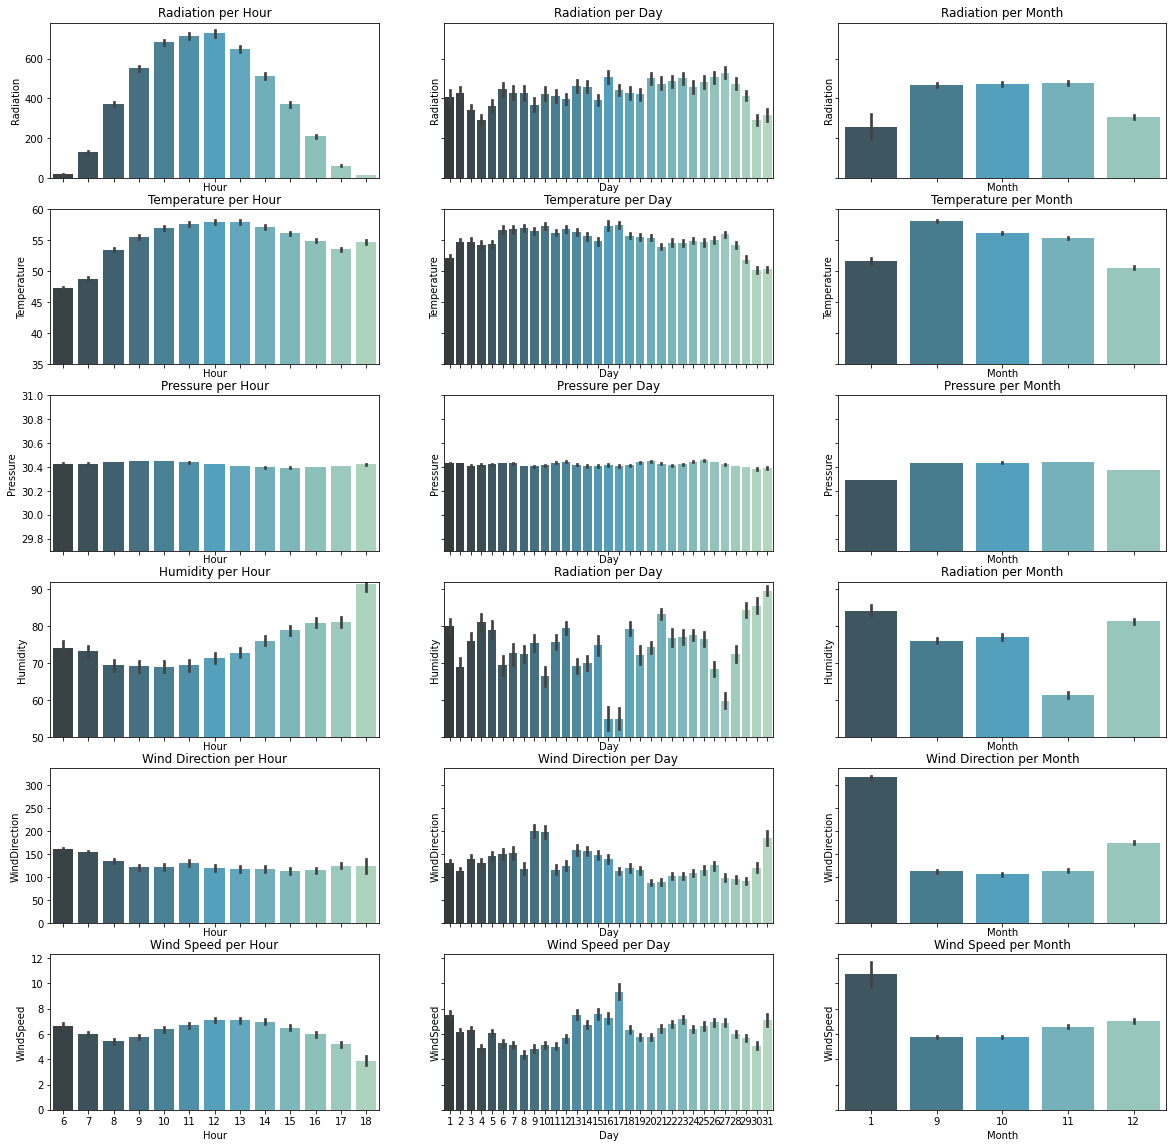

In [9]:
#@title Visualize parameter data at one time period
(
    f,
    (
        (ax1, ax2, ax3),
        (ax4, ax5, ax6),
        (ax7, ax8, ax9),
        (ax10, ax11, ax12),
        (ax13, ax14, ax15),
        (ax16, ax17, ax18),
    ),
) = plt.subplots(6, 3, sharex="col", sharey="row", figsize=(20, 20))

# Limit range of y values
ax4.set_ylim(35, 60)
ax7.set_ylim(29.7, 31)
ax10.set_ylim(50, 92)

# Plot 'Radiation' vs time unit
ax1.set_title("Radiation per Hour")
sns.barplot(x="Hour", y="Radiation", data=data, palette="GnBu_d", ax=ax1)
ax2.set_title("Radiation per Day")
sns.barplot(x="Day", y="Radiation", data=data, palette="GnBu_d", ax=ax2)
ax3.set_title("Radiation per Month")
sns.barplot(x="Month", y="Radiation", data=data, palette="GnBu_d", ax=ax3)

# Plot 'Temperature' vs time unit
ax4.set_title("Temperature per Hour")
sns.barplot(x="Hour", y="Temperature", data=data, palette="GnBu_d", ax=ax4)
ax5.set_title("Temperature per Day")
sns.barplot(x="Day", y="Temperature", data=data, palette="GnBu_d", ax=ax5)
ax6.set_title("Temperature per Month")
sns.barplot(x="Month", y="Temperature", data=data, palette="GnBu_d", ax=ax6)

# Plot 'Pressure' vs time unit
ax7.set_title("Pressure per Hour")
sns.barplot(x="Hour", y="Pressure", data=data, palette="GnBu_d", ax=ax7)
ax8.set_title("Pressure per Day")
sns.barplot(x="Day", y="Pressure", data=data, palette="GnBu_d", ax=ax8)
ax9.set_title("Pressure per Month")
sns.barplot(x="Month", y="Pressure", data=data, palette="GnBu_d", ax=ax9)

# Plot 'Humidity' vs time unit
ax10.set_title("Humidity per Hour")
sns.barplot(x="Hour", y="Humidity", data=data, palette="GnBu_d", ax=ax10)
ax11.set_title("Radiation per Day")
sns.barplot(x="Day", y="Humidity", data=data, palette="GnBu_d", ax=ax11)
ax12.set_title("Radiation per Month")
sns.barplot(x="Month", y="Humidity", data=data, palette="GnBu_d", ax=ax12)

# Plot 'WindDirection' vs time unit
ax13.set_title("Wind Direction per Hour")
sns.barplot(x="Hour", y="WindDirection", data=data, palette="GnBu_d", ax=ax13)
ax14.set_title("Wind Direction per Day")
sns.barplot(x="Day", y="WindDirection", data=data, palette="GnBu_d", ax=ax14)
ax15.set_title("Wind Direction per Month")
sns.barplot(x="Month", y="WindDirection", data=data, palette="GnBu_d", ax=ax15)

# Plot 'WindDirection' vs time unit
ax16.set_title("Wind Speed per Hour")
sns.barplot(x="Hour", y="WindSpeed", data=data, palette="GnBu_d", ax=ax16)
ax17.set_title("Wind Speed per Day")
sns.barplot(x="Day", y="WindSpeed", data=data, palette="GnBu_d", ax=ax17)
ax18.set_title("Wind Speed per Month")
sns.barplot(x="Month", y="WindSpeed", data=data, palette="GnBu_d", ax=ax18)


(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.,
        1600., 1800.]), <a list of 11 Text major ticklabel objects>)

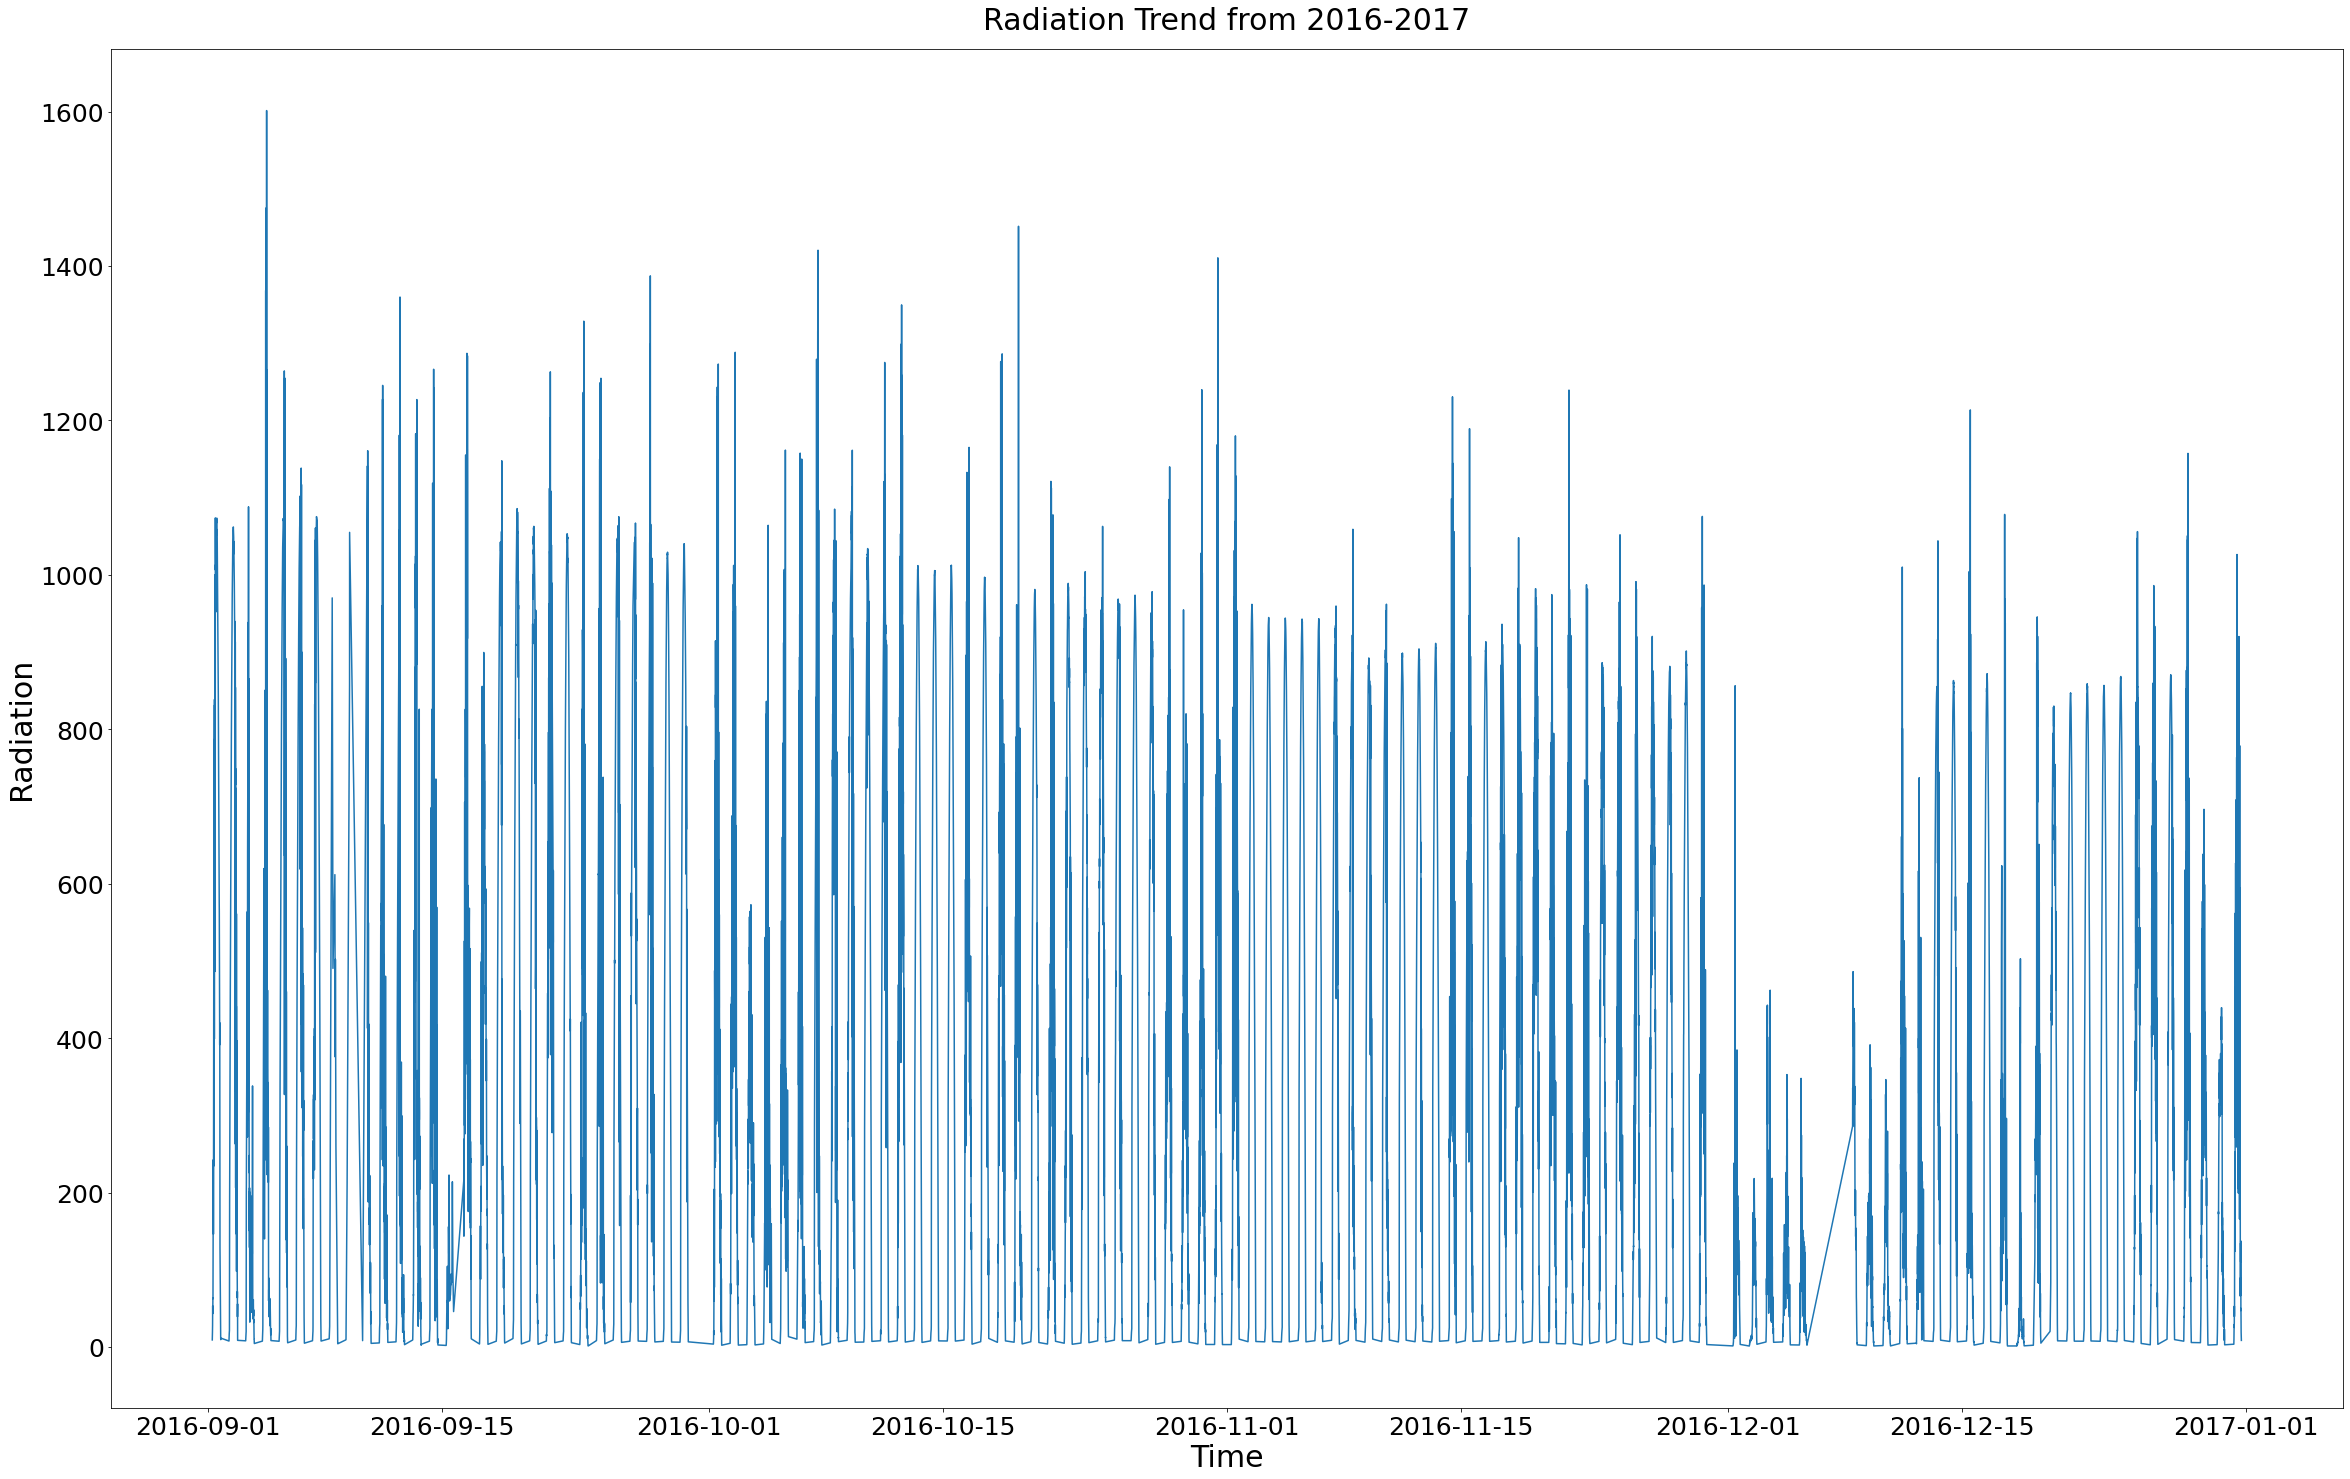

In [10]:
#@title Plot 'Radiation' from September 2016 to January 2017

data_viz = data.sort_values('DateTime', ascending=True)
data_viz.head(15)

plt.figure(figsize = (40,25))
plt.rcParams['agg.path.chunksize'] = 10000
plt.plot(data_viz['DateTime'], data_viz['Radiation'])

plt.title('Radiation Trend from 2016-2017', fontsize = 30, y = 1.01)
plt.xlabel('Time', fontsize = 30)
plt.xticks(fontsize = 25)
plt.ylabel('Radiation', fontsize = 30)
plt.yticks(fontsize = 25)

Text(0.5, 1.0, 'Correlation Table')

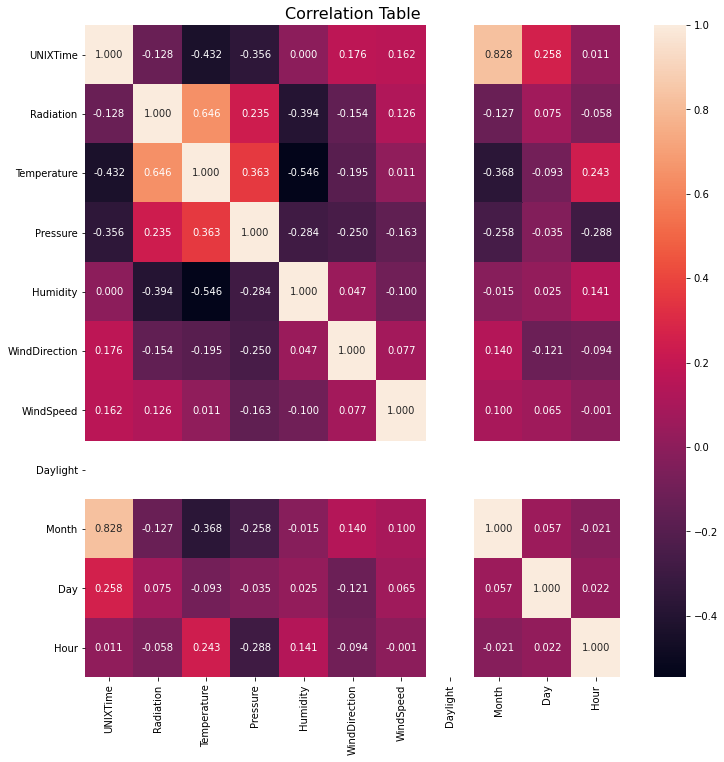

In [11]:
#@title Show correlation between each feature to other features

plt.figure(figsize = (12,12))
sns.heatmap(data.corr(), annot = True, fmt = '.3f')

plt.title('Correlation Table', fontsize = 16)

##Feature Engineering

In [12]:
#@title Normalize values

# Calculate the Z-scores of each column in the training set:
data_train_mean = data_train.select_dtypes(include=['float64', 'int64']).mean()
data_train_std = data_train.select_dtypes(include=['float64', 'int64']).std()
data_train_norm = (data_train.select_dtypes(include=['float64', 'int64']) 
                   - data_train_mean)/data_train_std

# Calculate the Z-scores of each column in the test set.
data_test_mean = data_test.select_dtypes(include=['float64', 'int64']).mean()
data_test_std = data_test.select_dtypes(include=['float64', 'int64']).std()
data_test_norm = (data_test.select_dtypes(include=['float64', 'int64'])
                  - data_test_mean)/data_test_std

print("Normalized")

Normalized


In [13]:
#@title Represent features as floating-point values

feature_columns = []

temperature = tf.feature_column.numeric_column("Temperature")
feature_columns.append(temperature)

pressure = tf.feature_column.numeric_column("Pressure")
feature_columns.append(pressure)

humidity = tf.feature_column.numeric_column("Humidity")
feature_columns.append(humidity)

wdirection = tf.feature_column.numeric_column("WindDirection")
feature_columns.append(wdirection)

wspeed = tf.feature_column.numeric_column("WindSpeed")
feature_columns.append(wspeed)

#sunrise = tf.feature_column.numeric_column("Sunrise")
#feature_columns.append(sunrise)

#sunset = tf.feature_column.numeric_column("Sunset")
#feature_columns.append(sunset)

#month = tf.feature_column.numeric_column("Month")
#feature_columns.append(month)

#day = tf.feature_column.numeric_column("Day")
#feature_columns.append(day)

hour = tf.feature_column.numeric_column("Hour")
feature_columns.append(hour)

#minute = tf.feature_column.numeric_column("Minute")
#feature_columns.append(minute)

# Convert the list of feature columns into a layer that 
# later will be fed into the model. 
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

print('Represented')

Represented


##Model: Linear Regression

In [14]:
#@title Define plotting function

"""Plot loss vs epoch in a graph"""
def plot_the_loss_curve(epochs, rmse_training, rmse_validation):
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Root Mean Squared Error')

  plt.plot(epochs[1:], rmse_training[1:], label='Training Loss')
  plt.plot(epochs[1:], rmse_validation[1:], label='Validation Loss')
  plt.legend()

  merged_rmse_lists = rmse_training[1:] + rmse_validation[1:]
  highest_loss = max(merged_rmse_lists)
  lowest_loss = min(merged_rmse_lists)
  delta = highest_loss - lowest_loss
  print(delta)

  top_of_y_axis = highest_loss + (delta * 0.05)
  bottom_of_y_axis = lowest_loss - (delta * 0.05)
  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.show()  

print('Defined')

Defined


In [15]:
#@title Define functions to create and train  model

"""Create and compile a simple linear regression model."""
def create_model(learning_rate, feature_layer):
  
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(feature_layer)

  # Add one linear layer to the model to yield a simple linear regressor.
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))

  # Construct the layers into a model that TensorFlow can execute.
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=learning_rate),
                loss='mean_squared_error',
                metrics=[tf.keras.metrics.RootMeanSquaredError()])
  
  return model           

"""Feed a dataset into the model in order to train it."""
def train_model(model, dataset, epochs, batch_size,
                label_name, validation_split):

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, validation_split=validation_split, 
                      shuffle=True)

  # Get details that will be useful for plotting the loss curve.
  epochs = history.epoch
  hist = pd.DataFrame(history.history)
  rmse = hist['root_mean_squared_error']

  return epochs, rmse, history.history   

print('Defined')

Defined


Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

8/8 [==============================] - 0s 32ms/step - loss: 2.0650 - root_mean_squared_error: 1.4483 - val_loss: 1.7505 - val_root_mean_squared_error: 1.3265
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 1.6360 - root_mean_squared_error: 1.2798 - val_loss: 1.4328 - val_root_mean_squared_error: 1.1999
Epoch 3/100
8/8 [==============================] - 0s 12ms/step - loss: 1.3509 - root_mean_squared_error: 1.1682 - val_loss: 1.2109 - val_root_mean_squared_error: 1.1026

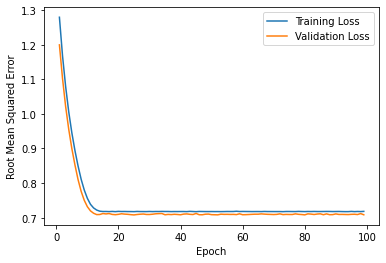


 Evaluate the linear regression model against the test set:
1/1 [==============================] - 0s 2ms/step - loss: 0.4314 - root_mean_squared_error: 0.6568


[0.43141284584999084, 0.6568202376365662]

In [16]:
#@title Train model

# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 100
batch_size = 1024
validation_split = 0.5
label_name = 'Radiation'
 
# Establish the model's topography.
model = create_model(learning_rate, feature_layer)

# Train the model on the normalized training set.
epochs, rmse, history = train_model(model, data_train_norm, epochs, batch_size,
                                    label_name, validation_split=validation_split)
plot_the_loss_curve(epochs, history['root_mean_squared_error'], 
                    history['val_root_mean_squared_error'])

test_features = {name:np.array(value) for name, value in data_test_norm.items()}
# Isolate the label
test_label = np.array(test_features.pop(label_name))
print('\n Evaluate the linear regression model against the test set:')
model.evaluate(x=test_features, y=test_label, batch_size=batch_size)